In [1]:
using Pkg
Pkg.activate(".")

using SimilaritySearch, SimSearchManifoldLearning, TextSearch, InvertedFiles,
    CodecZlib, JSON, JLD2, LinearAlgebra, TOML, Glob, Base64,
    CategoricalArrays, StatsPlots, StatsBase, Statistics,
    Clustering, Query, DataFrames, Languages, Snowball, Markdown

using Downloads: download

  Activating project at `~/Tools/Search-Julia-Packages`


In [2]:
include("src/create-indexes.jl")

load_or_create_indexes (generic function with 1 method)

In [3]:
P = load_or_create_indexes()

(D = 8944×7 DataFrame
  Row │ name                url                                description     ⋯
      │ String              String                             String          ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ AAindex             https://github.com/jowch/AAindex…  A package to re ⋯
    2 │ ABBAj               https://github.com/nla-group/ABB…  A Julia version
    3 │ ABC_jll             https://github.com/JuliaBinaryWr…
    4 │ ACME                https://github.com/HSU-ANT/ACME.…  ACME.jl - Analo
    5 │ ACTRModels          https://github.com/itsdfish/ACTR…  A Julia Package ⋯
    6 │ ACTRSimulators      https://github.com/itsdfish/ACTR…  A Julia package
    7 │ AD4SM               https://github.com/avigliotti/AD…  Automatic Diffe
    8 │ ADCME               https://github.com/kailaix/ADCME…  Automatic Diffe
    9 │ ADCMEKit            https://github.com/kailaix/ADCME…  Make Inverse Mo ⋯
   10 │ ADI                 https:/

In [4]:
const STOP_WORDS = Set(stopwords(Languages.English()))
union!(STOP_WORDS, ["_url", "julia", "install", "imag", "img", "src", "href", "docs", "api", "status", "com", "org", "url"])
union!(STOP_WORDS, ["dev", "git", "pull", "request", "contributing", "pullrequest", "pr", "branch", "stable", "dev", "develop", "license", "package", "codecov", "travis", "github", "gitlab", "coverage", "ci", "coveralls", "coverall"])
union!(STOP_WORDS, ["doc", "code", "struct", "eval", "evaluate", "docs", "documentation", "bib", "citation", "paper", "bibtex", "etc", "welcome", "et", "al", "wip"])
union!(STOP_WORDS, ["im", "re", "pkg", "add", "package", "module", "dev", "build", "using", "import", "script", "release", "jl", "julia"])

const STEM = [Stemmer("english") for _ in 1:Threads.nthreads()]

struct MyTokenTransformation <: AbstractTokenTransformation
end

function TextSearch.transform_unigram(::MyTokenTransformation, tok)
    tok in STOP_WORDS && return nothing
    stem(STEM[Threads.threadid()], tok)
end

function text_model_and_vectors(corpus, labels)
    textconfig = TextConfig(
        group_usr=false,
        group_url=true,
        del_diac=true,
        del_punc=true,
        lc=true,
        group_num=true,
        nlist=[1, 2],
        qlist=[],
        tt=MyTokenTransformation()
    )
    voc = filter_tokens(Vocabulary(textconfig, corpus)) do t
        10 < t.ndocs < 3000
    end

    if labels === nothing
        model = VectorModel(IdfWeighting(), TfWeighting(), voc)
    else
        model = VectorModel(EntropyWeighting(), TfWeighting(), voc, corpus, categorical(labels);
                mindocs=3, smooth=1.0)
    end
        
	vectors = vectorize_corpus(model, corpus)
    
    model, vectors
end



text_model_and_vectors (generic function with 1 method)

In [5]:
#dropmissing!(D, :description)
#M = text_model_and_vectors(D.description, nothing)
T = let
    corpus = [join((name, topics, description), "\n")
                    for (name, topics, description) in zip(P.D.name, P.D.topics, P.D.description)]
    model, vectors = text_model_and_vectors(corpus, nothing)

    @info "this can take a while depending on the number of threads and the speed of your system"
    # we use Exhaustive search instead of `SearchGraph` (create_index) because the dataset is quite small
    # and high dimensional, these both are bad combinations for any index
    index = ExhaustiveSearch(; db=vectors, dist=NormalizedCosineDistance()) # create_index(D.vectors, indexfile)
    (; model, vectors, index)
end

length(T.index)

[ Info: this can take a while depending on the number of threads and the speed of your system


8944

In [6]:
function create_umap_embeddings(index; force=true, k=15, n_epochs=100, neg_sample_rate=3, tol=1e-4, layout=RandomLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
	(e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(D, e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="")
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
    ##scatter(X, Y, c=levelcode.(categorical(corpus.label)), fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=4, msw=0, label="", color_palette=:rainbow)
    ##plot!(title="colors are related to labels")
    ###S = rand(1:length(X), 200)
    ###annotate!(X[S], Y[S], text.(D.labels[S], 0.3, 8, "NotoColorEmoji"))
end

plot_umap (generic function with 1 method)

## Computing KNN graph

The non-linear projections need the knn graph. We also save

In [7]:
knns, dists = allknn(T.index, 15)
jldsave("data/package-all-knns-10.jld2"; knns, dists)

In [8]:
display(md"### computing the umap embedding (2d and 3d for colors)")
e2, e3 = create_umap_embeddings(PrecomputedKnns(knns, dists); k=15, tol=1e-4, layout=SpectralLayout());
jldsave("data/umap-embeddings.jld2"; e2, e3)

### computing the umap embedding (2d and 3d for colors)


  0.001017 seconds (5 allocations: 1.024 MiB)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


  4.199683 seconds (2.65 M allocations: 1.383 GiB, 2.41% gc time, 53.26% compilation time: <1% of which was recompilation)


UMAP construction time cost report:
- fuzzy graph: 0.140143008
- embedding init: 2.737939335
- embedding opt: 0.909277147



  1.183487 seconds (339 allocations: 274.234 KiB)


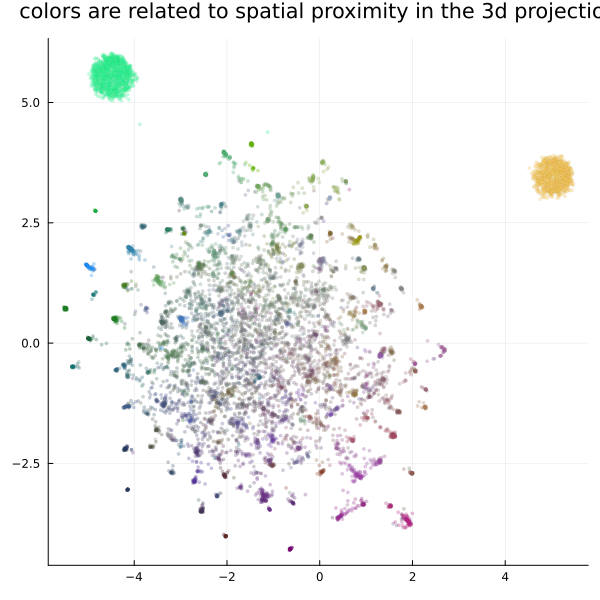

In [9]:
plot_umap(T, e2, e3)

In [10]:
function compute_epsilon(emb; m=100, k=7)
    db = MatrixDatabase(emb)
    E = ExhaustiveSearch(; dist=L2Distance(), db)
    queries = rand(db, m)
    I, D = searchbatch(E, queries, k)
    histogram(last.(eachcol(D)))
end

compute_epsilon (generic function with 1 method)

## Parameters for filtering regions with low-density

Determining some way to filter low dense regions

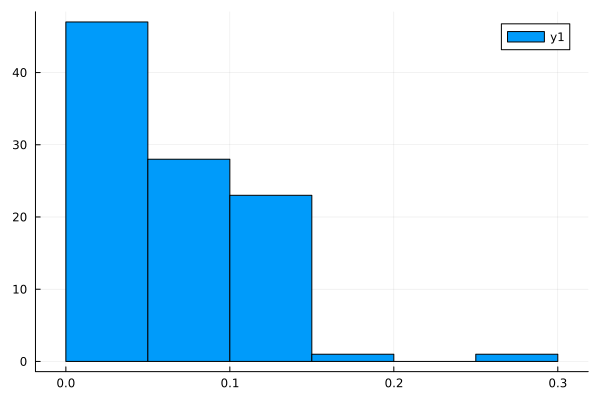

In [11]:
compute_epsilon(e2, k=10)

## Computing DBSCAN clusters

In [12]:
clusters_ = dbscan(e2, 0.05, min_cluster_size=5)
jldsave("data/clusters.jld2"; clusters=clusters_)

## Clusters after low-density removal

Colors were automatically asigned contrary to previous plots


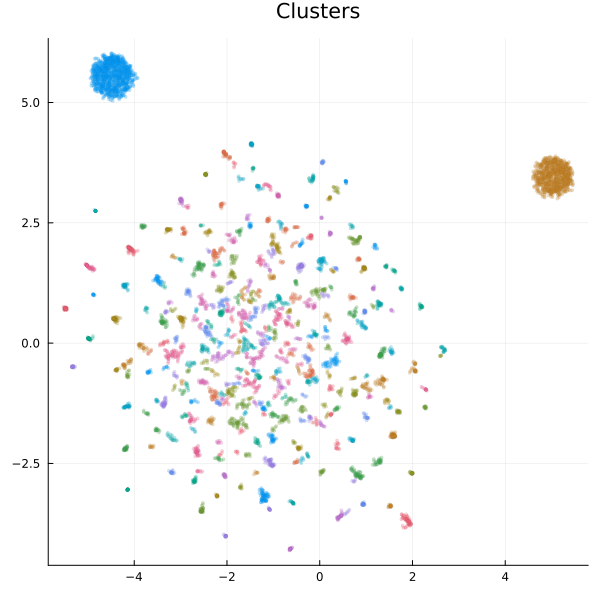

In [13]:
# [length(c.core_indices) for c in clusters_] |> sum
plot()

token_(t) = startswith(t, "\t") ? t[3:end] : t
D = P.D
let res=KnnResult(100), voc=T.model.voc, bow=Dict{UInt32,Float32}()
    
    for c in clusters_
        X = @view e2[1, c.core_indices]
        Y = @view e2[2, c.core_indices]
        scatter!(X, Y, c=:auto, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="")
        #=if rand() < 1.0
            #### HERE WE CAN INSPECT OR SAVE CLUSTERS ####
            println("======================== ", length(c.core_indices), " ===================")
            #foreach(p->print(p, " "), countmap(C.label[c.core_indices]))
            println()
            println("==========")
            
            empty!(bow)
            for i in c.core_indices
                V = T.vectors[i]
                length(V) == 1 && continue  # empty vectors 
                TextSearch.add!(bow, V)
            end
            println(D.url[c.core_indices])
            println(D.topics[c.core_indices])
            println(D.description[c.core_indices])
            println(c.core_indices)
            
            res = reuse!(res)
            for (tokenID, weight) in bow
                push_item!(res, tokenID, -weight)
            end
            
            for p in res
                print(token_(voc.token[p.id]), " => ", -round(p.weight; digits=3), "; ")
            end
                
            println()
            
        end
        =#
    end
end

display(md"""
## Clusters after low-density removal
    
Colors were automatically asigned contrary to previous plots
""")

plot!(title="Clusters")